In [6]:
import numpy as np
from scipy import fftpack
import tensorly as tl
from util import square_tensor_gen, TensorInfoBucket, RandomInfoBucket, eval_mse, eval_rerr
from sketch import Sketch
import time
from tensorly.decomposition import tucker
from sketch_recover import SketchTwoPassRecover
from sketch_recover import SketchOnePassRecover
import matplotlib 
import matplotlib.pyplot as plt
from simulation import Simulation
import matplotlib.ticker as ticker
import pickle 
plt.style.use('seaborn-paper')
%matplotlib inline 

In [7]:
def sim_name(gen_type,r,noise_level,dim): 
    if noise_level == 0: 
        noise = "no"
    else: 
        noise = str(int(np.log10(noise_level)))
    return "data/typ"+gen_type+"_r"+str(r)+"_noise"+noise+"_dim"+str(dim)

In [8]:
def run_nssim(gen_type,r,noise_level, ns = np.arange(100,101,100), dim = 3, sim_runs = 1,random_seed = 1): 
    sim_list = []
    for id, n in enumerate(ns): 
        if gen_type in ['id','lk']: 
            ks =np.arange(r, int(n/2),int(n/20)) 
        elif gen_type in ['spd','fpd']: 
            ks = np.arange(r,int(n/50),int(n/50))
        else: 
            ks = np.arange(r,int(n/100),int(n/100))
        ho_svd_rerr = np.zeros((sim_runs, len(ks)))
        two_pass_rerr = np.zeros((sim_runs,len(ks)))
        one_pass_rerr = np.zeros((sim_runs,len(ks)))
        for i in range(sim_runs): 
            for idx, k in enumerate(ks): 
                simu = Simulation(np.repeat(n,dim), r, k, 2*k+1, RandomInfoBucket(random_seed), gen_type, noise_level)
                _, rerr = simu.ho_svd()
                ho_svd_rerr[i,idx] = rerr 
                _, rerr = simu.two_pass() 
                two_pass_rerr[i,idx] = rerr
                _, rerr = simu.one_pass()
                one_pass_rerr[i,idx] = rerr 
        sim_list.append([two_pass_rerr,one_pass_rerr,ho_svd_rerr])
    pickle.dump( sim_list, open(sim_name(gen_type,r,noise_level,dim) +".pickle", "wb" ) )
    return sim_list

In [39]:
def plot_nssim(gen_type,r,noise_level,name,n, ns = [200,400,600], dim = 3, sim_runs = 1,random_seed = 1,fontsize = 18): 
    plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
    plt.rc('text', usetex=True)
    sim_list = pickle.load( open( sim_name(gen_type,r,noise_level,dim)+".pickle", "rb" ) ) 
    plot_id = ns.index(n)
    if gen_type in ['id','lk']: 
        ks =np.arange(r, int(n/2),int(n/20)) 
    elif gen_type in ['spd','fpd']: 
        ks = np.arange(r,int(n/5),int(n/50))
    else: 
        ks = np.arange(r,int(n/10),int(n/100))
    plt.figure(figsize=(6,5))
    plt.plot(ks/n,np.mean(sim_list[plot_id][0],0), label = 'Two Pass',linestyle = '--',marker = 'X')
    plt.plot(ks/n,np.mean(sim_list[plot_id][1],0), label = 'One Pass', marker = 's',markeredgewidth=1,markeredgecolor='orange', markerfacecolor='None') 
    plt.plot(ks/n,np.mean(sim_list[plot_id][2],0), label = 'Tucker', linestyle = ':', marker = 'o', markeredgewidth=1,markeredgecolor='g', markerfacecolor='None') 
    plt.legend(loc = 'best')
    plt.title("I = %s"%(n))
    plt.xlabel('k/I')
    plt.ylabel('Relative Error')
    plt.yscale('log')
    plt.minorticks_off()
    alldata = np.concatenate((np.mean(sim_list[plot_id][0],0),np.mean(sim_list[plot_id][1],0),np.mean(sim_list[plot_id][2],0)))
    ymin = min(alldata)
    ymax = max(alldata) 
    
    def round_to_n(x,n): 
        return round(x,-int(np.floor(np.log10(abs(x))))+n-1) 
    ticks = [round_to_n(i,3) for i in np.arange(ymin, ymax+(ymax-ymin)/5,(ymax-ymin)/5)] 
    plt.yticks(ticks)
    plt.axes().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2e')) 
    plt.axes().title.set_fontsize(fontsize)
    plt.axes().xaxis.label.set_fontsize(fontsize)
    plt.axes().yaxis.label.set_fontsize(fontsize)
    plt.rc('legend',fontsize = fontsize)
    plt.rc('xtick', labelsize = fontsize) 
    plt.rc('ytick', labelsize = fontsize) 
    plt.tight_layout()
    plt.savefig('plots/'+name)
    plt.show()

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


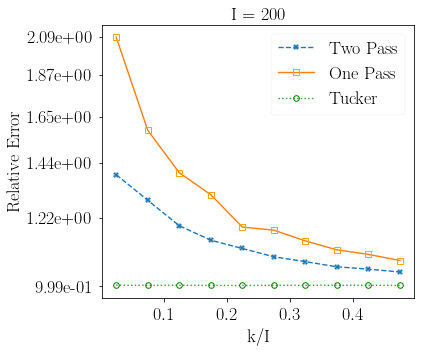

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


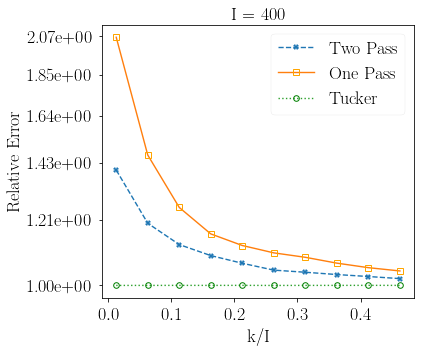

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


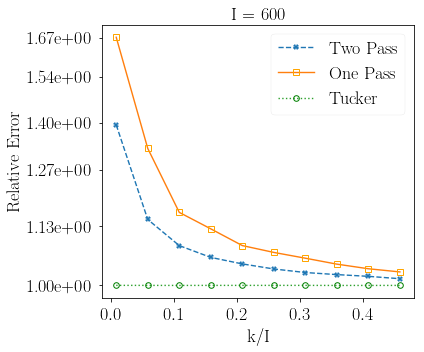

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


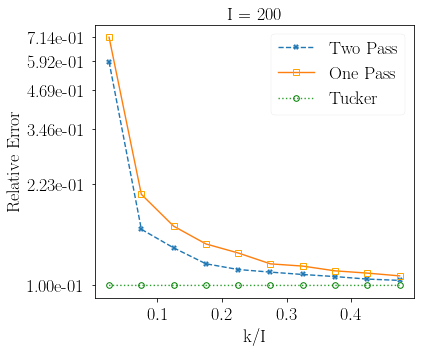

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


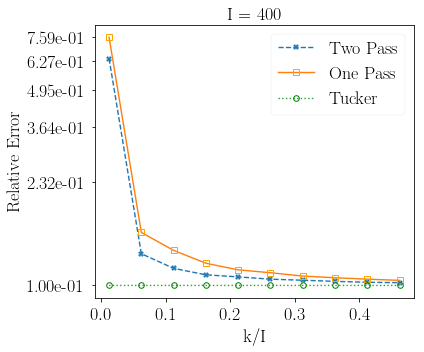

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


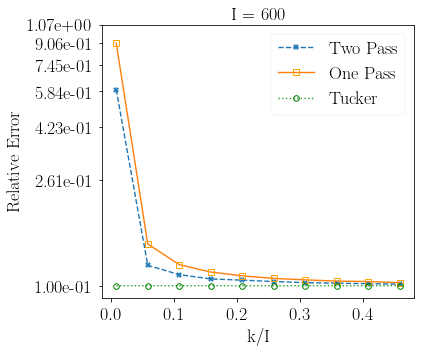

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


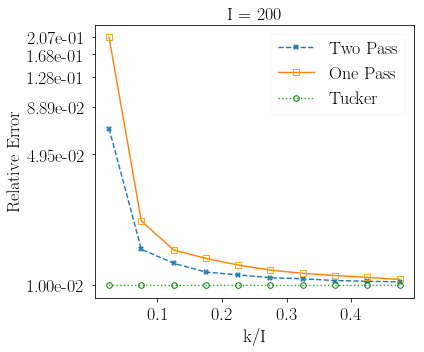

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


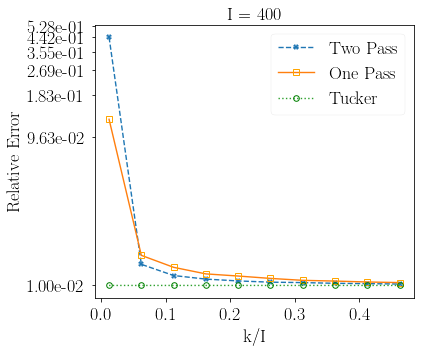

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


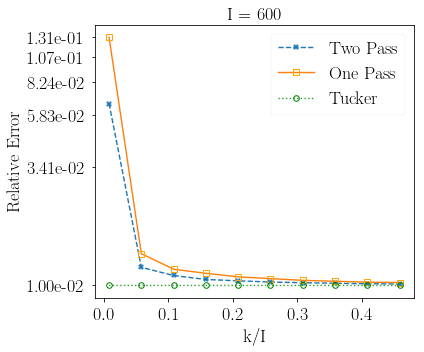

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


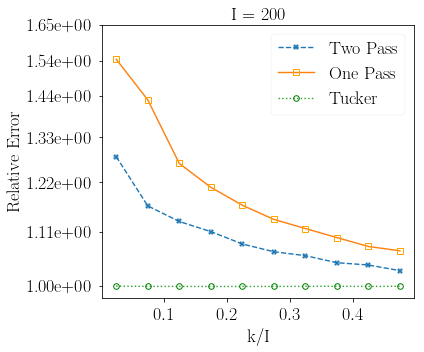

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


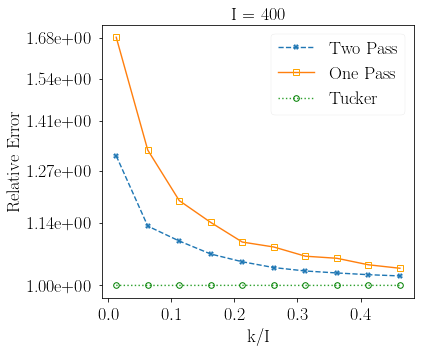

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


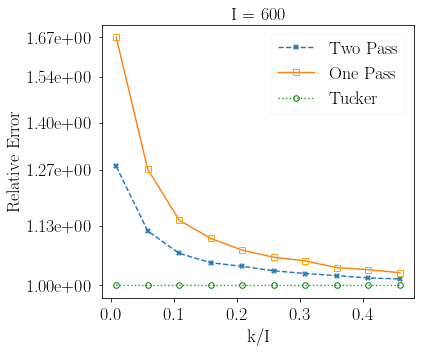

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


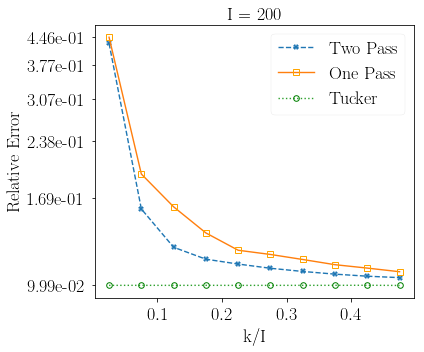

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


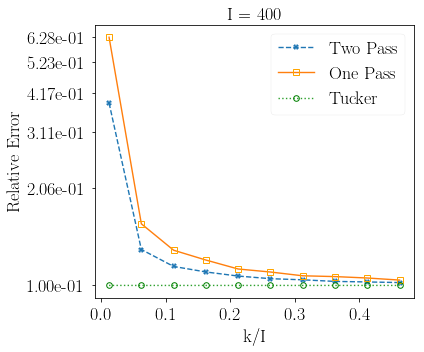

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


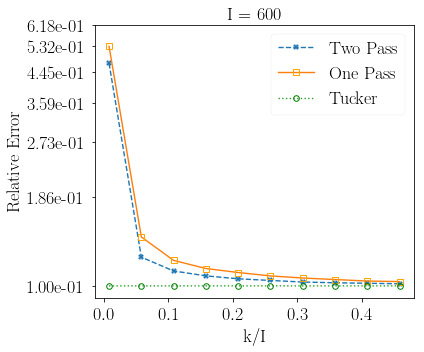

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


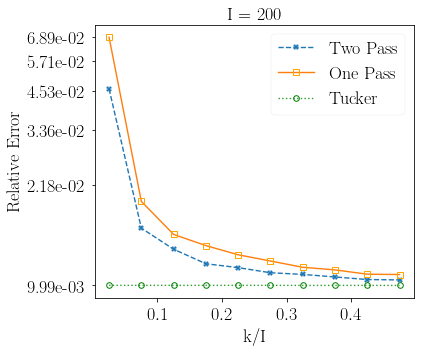

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


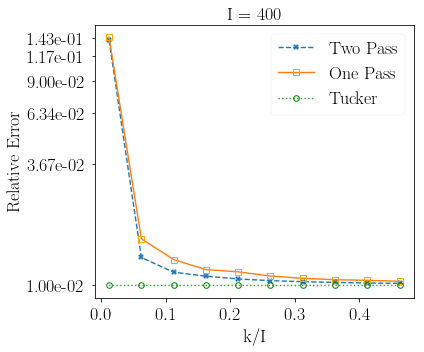

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


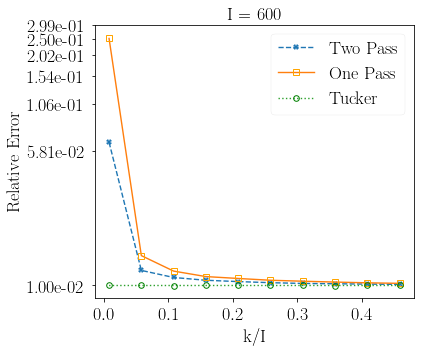

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


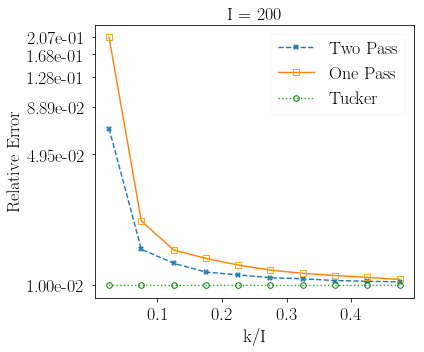

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


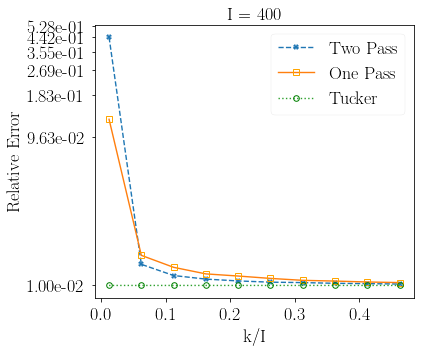

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


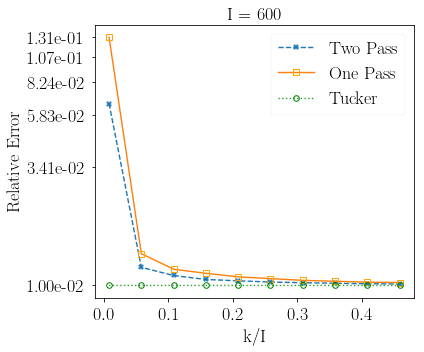

In [40]:
plot_nssim('id',5,1,"id_hnoise_n200.pdf",200)
plot_nssim('id',5,1,"id_hnoise_n400.pdf",400)
plot_nssim('id',5,1,"id_hnoise_n600.pdf",600)
plot_nssim('id',5,0.1,"id_mnoise_n200.pdf",200)
plot_nssim('id',5,0.1,"id_mnoise_n400.pdf",400)
plot_nssim('id',5,0.1,"id_mnoise_n600.pdf",600)
plot_nssim('id',5,0.01,"id_lnoise_n200.pdf",200)
plot_nssim('id',5,0.01,"id_lnoise_n400.pdf",400)
plot_nssim('id',5,0.01,"id_lnoise_n600.pdf",600)
plot_nssim('lk',5,1,"lk_hnoise_n200.pdf",200)
plot_nssim('lk',5,1,"lk_hnoise_n400.pdf",400)
plot_nssim('lk',5,1,"lk_hnoise_n600.pdf",600)
plot_nssim('lk',5,0.1,"lk_mnoise_n200.pdf",200)
plot_nssim('lk',5,0.1,"lk_mnoise_n400.pdf",400)
plot_nssim('lk',5,0.1,"lk_mnoise_n600.pdf",600)
plot_nssim('lk',5,0.01,"lk_lnoise_n200.pdf",200)
plot_nssim('lk',5,0.01,"lk_lnoise_n400.pdf",400)
plot_nssim('lk',5,0.01,"lk_lnoise_n600.pdf",600)

plot_nssim('id',5,0.01,"id_rk1_n200.pdf",200)
plot_nssim('id',5,0.01,"id_rk1_n400.pdf",400)
plot_nssim('id',5,0.01,"id_rk1_n600.pdf",600)

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


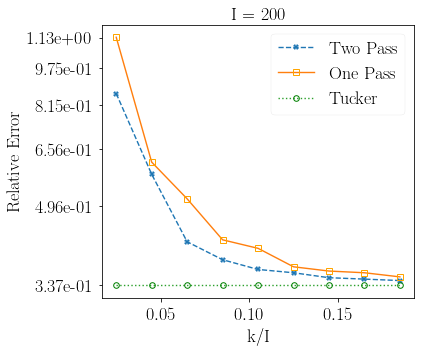

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


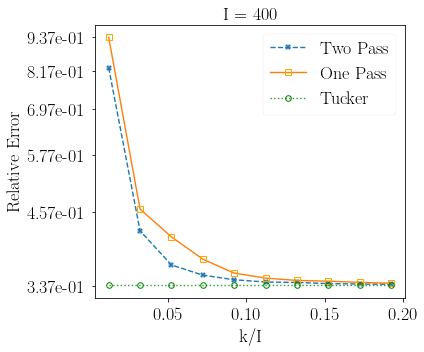

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


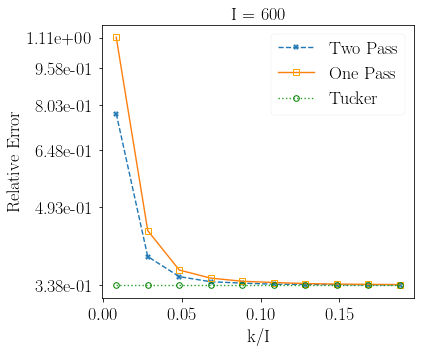

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


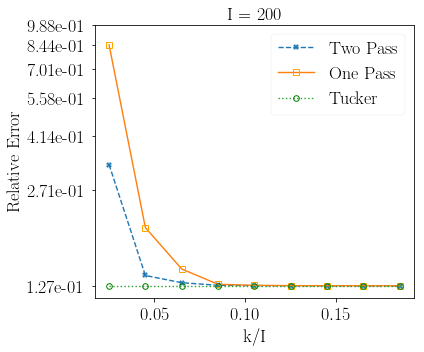

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


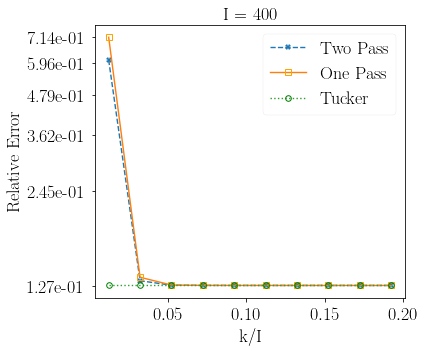

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


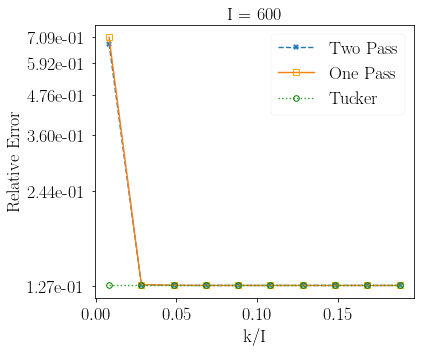

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


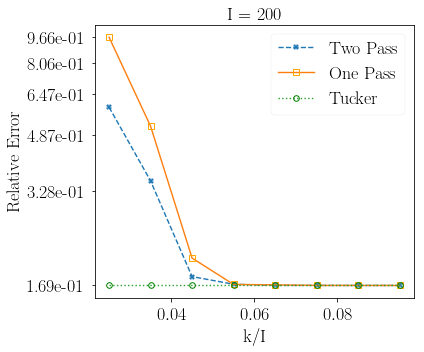

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


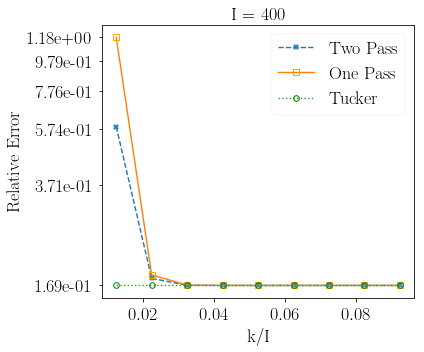

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


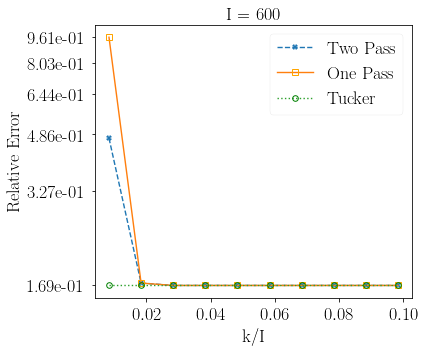

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


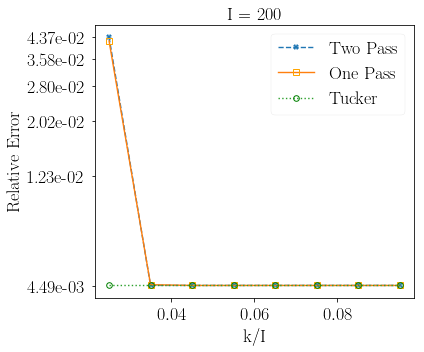

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


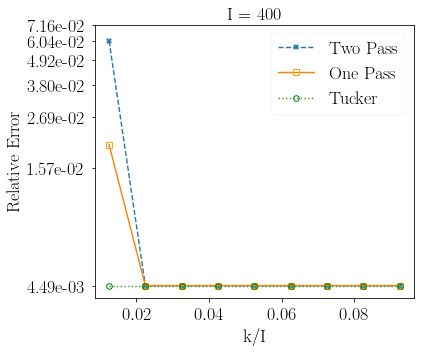

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


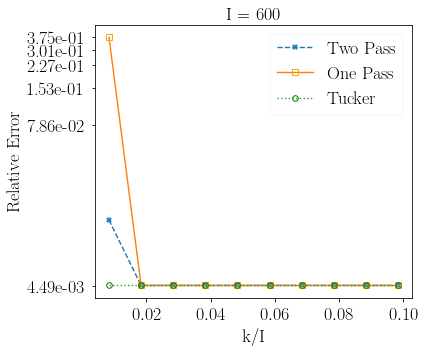

In [41]:
plot_nssim('spd',5,0.01,"spd_n200.pdf",200)
plot_nssim('spd',5,0.01,"spd_n400.pdf",400)
plot_nssim('spd',5,0.01,"spd_n600.pdf",600)
plot_nssim('fpd',5,0.01,"fpd_n200.pdf",200)
plot_nssim('fpd',5,0.01,"fpd_n400.pdf",400)
plot_nssim('fpd',5,0.01,"fpd_n600.pdf",600)



plot_nssim('sed',5,0.01,"sed_n200.pdf",200)
plot_nssim('sed',5,0.01,"sed_n400.pdf",400)
plot_nssim('sed',5,0.01,"sed_n600.pdf",600)
plot_nssim('fed',5,0.01,"fed_n200.pdf",200)
plot_nssim('fed',5,0.01,"fed_n400.pdf",400)
plot_nssim('fed',5,0.01,"fed_n600.pdf",600)
